# CS 584 Final Project 
# DETECTING DISCUSSION TOPICS AND SENTIMENT IN REDDIT THREADS <br>


#### Name: Uros Nikolic and Sam Preston
#### Stevens ID: 20017063, 10463953

In [2]:
# Library imports

%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pa
import torch
import torch.nn as nn 
import sys
import os
import random
import evaluate
from textblob import TextBlob
from torchinfo import summary
from typing import List, Tuple, Union, Dict
from datasets import load_dataset
from tokenizers import Tokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score

In [3]:
def print_line(*args):
    """ Inline print and go to the begining of line
    """
    args1 = [str(arg) for arg in args]
    str_ = ' '.join(args1)
    print('\r' + str_, end='')

In [4]:
# Important pip commands for installing some of the neccesasry libraries. 

#!pip install torch
#!pip uninstall torch torchvision torchaudio

#!pip install -U datasets

#!pip install tokenizers

#!pip install torchinfo

#!pip install evaluate
#!pip install sacrebleu

#!pip install textblob
#python -m textblob.download_corpora


In [5]:
# Testing the Cuda cores on personal machine
print(torch.cuda.is_available())           
print(torch.cuda.get_device_name(0))

True
NVIDIA GeForce RTX 4070 Laptop GPU


In [6]:
# Data extratcion

controversialPosts = pa.read_csv('data/controversial_posts.csv')
controversialPostComments = pa.read_csv('data/controversial_posts_comments.csv')
hotPost = pa.read_csv('data/hot_posts.csv')
hotPostComments = pa.read_csv('data/hot_post_comments.csv')
newPost = pa.read_csv('data/new_posts.csv')
newPostComments = pa.read_csv('data/new_post_comments.csv')
topPost = pa.read_csv('data/top_posts.csv')
topPostComments = pa.read_csv('data/top_posts_comments.csv')

In [7]:
def extract_text(df, post=True):
    if post:
        df['body']  = df.get('body','').fillna('')
        df['title'] = df.get('title','').fillna('')
        df['text']  = (df['title'].str.strip() + ' ' + df['body'].str.strip()).str.strip()
    else:
        df['body'] = df.get('body', df.get('comment','')).fillna('')
        df['text'] = df['body'].str.strip()
    return df[df['text']!='']

In [8]:
posts = pa.concat([
    extract_text(controversialPosts, post=True),
    extract_text(hotPost,         post=True),
    extract_text(newPost,         post=True),
    extract_text(topPost,         post=True),
], ignore_index=True)

comments = pa.concat([
    extract_text(controversialPostComments, post=False),
    extract_text(hotPostComments,           post=False),
    extract_text(newPostComments,           post=False),
    extract_text(topPostComments,           post=False),
], ignore_index=True)

print(f"Loaded {len(posts)} posts, {len(comments)} comments.")
print(f"Loaded {posts["score"]} posts.")

Loaded 3792 posts, 113310 comments.
Loaded 0        11
1         0
2         0
3       303
4         0
       ... 
3787    820
3788    821
3789    825
3790    824
3791    817
Name: score, Length: 3792, dtype: int64 posts.


In [9]:
from textblob import TextBlob

# ─────────────────────────────────────────────────────────────────────────────
# 3) COMBINE POSTS+COMMENTS & DERIVE SENTIMENT VIA TEXTBLOB
# ─────────────────────────────────────────────────────────────────────────────
data = pa.concat([
    posts   [['text']],
    comments[['text']]
], ignore_index=True)

# compute polarity ∈ [−1,1], then binarize:
data['polarity'] = data['text'].apply(lambda t: TextBlob(t).sentiment.polarity)
data['sentiment'] = (data['polarity'] >= 0).astype(int)

print("Sentiment distribution:\n", data['sentiment'].value_counts(normalize=True))


Sentiment distribution:
 sentiment
1    0.7564
0    0.2436
Name: proportion, dtype: float64


In [10]:
# Code Body

# ─────────────────────────────────────────────────────────────────────────────
# 4) TF-IDF + TRAIN/TEST SPLIT
# ─────────────────────────────────────────────────────────────────────────────
X = data['text']
y = data['sentiment']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)


In [11]:
# Logistic Regression for multi-class topic classification

models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'NaiveBayes':         MultinomialNB(),
    'LinearSVM':          LinearSVC(max_iter=2000, random_state=42),
    'RandomForest':       RandomForestClassifier(n_estimators=100, random_state=42),
    'MLP':                MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42),
}

results = []
for name, clf in models.items():
    print(f"\n>>> Training {name}")
    clf.fit(X_train_tfidf, y_train)
    y_pred = clf.predict(X_test_tfidf)
    acc   = accuracy_score(y_test, y_pred)
    prec  = precision_score(y_test, y_pred)
    rec   = recall_score(y_test, y_pred)
    f1    = f1_score(y_test, y_pred)
    print(f"Acc={acc:.3f}  Prec={prec:.3f}  Rec={rec:.3f}  F1={f1:.3f}")
    results.append((name, acc, prec, rec, f1))

res_df = pa.DataFrame(results, columns=['Model','Accuracy','Precision','Recall','F1'])
print("\nSummary:\n", res_df)

best = res_df.sort_values('F1', ascending=False).iloc[0]['Model']
print(f"\nDetailed report for {best}:\n")
print(classification_report(y_test, models[best].predict(X_test_tfidf)))


>>> Training LogisticRegression
Acc=0.905  Prec=0.909  Rec=0.972  F1=0.939

>>> Training NaiveBayes
Acc=0.841  Prec=0.831  Rec=0.991  F1=0.904

>>> Training LinearSVM
Acc=0.919  Prec=0.931  Rec=0.965  F1=0.948

>>> Training RandomForest
Acc=0.927  Prec=0.951  Rec=0.953  F1=0.952

>>> Training MLP
Acc=0.936  Prec=0.948  Rec=0.968  F1=0.958

Summary:
                 Model  Accuracy  Precision    Recall        F1
0  LogisticRegression  0.904914   0.909004  0.971551  0.939238
1          NaiveBayes  0.840613   0.830990  0.990799  0.903885
2           LinearSVM  0.919303   0.930569  0.965342  0.947637
3        RandomForest  0.926775   0.950707  0.952585  0.951645
4                 MLP  0.935571   0.947534  0.968447  0.957876

Detailed report for MLP:

              precision    recall  f1-score   support

           0       0.89      0.83      0.86      5705
           1       0.95      0.97      0.96     17716

    accuracy                           0.94     23421
   macro avg       0.92 

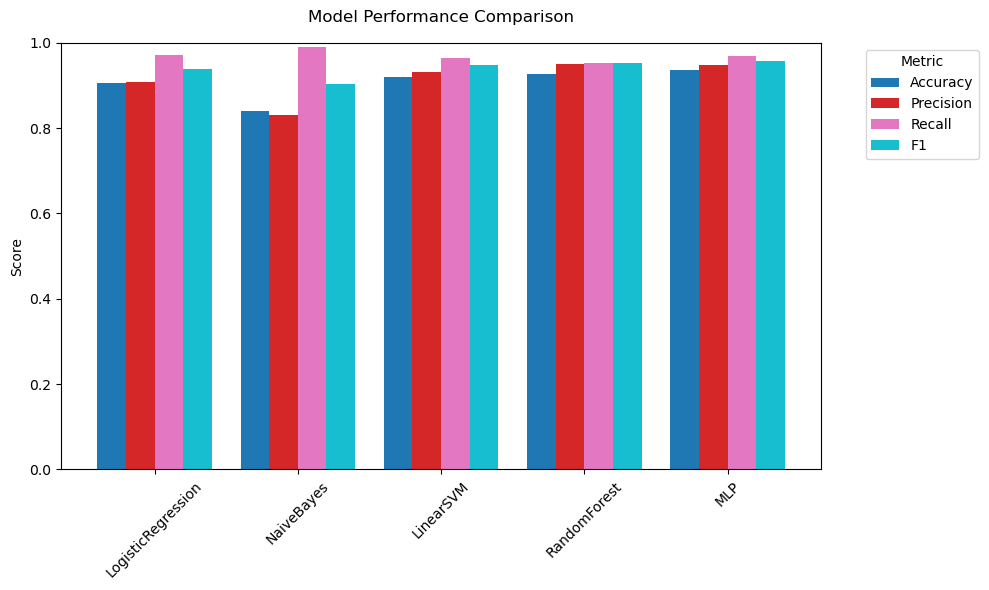

In [12]:
# Plotting the results Results

# ─────────────────────────────────────────────────────────────────────────────
# 6) PLOT COMPARISON ACROSS MODELS
# ─────────────────────────────────────────────────────────────────────────────
import matplotlib.pyplot as plt

# set the ‘Model’ column as the index so pandas will label the x‐axis
plot_df = res_df.set_index('Model')

# select only the metric columns
metrics = ['Accuracy','Precision','Recall','F1']

# plot a grouped bar chart
ax = plot_df[metrics].plot(
    kind='bar', 
    figsize=(10,6), 
    ylim=(0.0,1.0),    # scores are between 0 and 1
    width=0.8,
    rot=45,
    colormap='tab10'
)

ax.set_title('Model Performance Comparison', pad=15)
ax.set_ylabel('Score')
ax.set_xlabel('')
ax.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [13]:
# Final conclusion